In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
from scipy.stats import norm

In [3]:
df_price = pd.read_csv(r"C:\Users\Asus\Documents\Coding\SET code\SOMC\After Discuss\SET 50 Historical Data (9).csv")

In [4]:
df_price

,Date,Price,Open,High,Low,Vol.,Change %
0,05/22/2025,768.11,766.70,772.60,765.78,1.03B,-0.17%
1,05/21/2025,769.40,777.86,782.88,766.29,1.65B,-0.67%
2,05/20/2025,774.62,777.30,781.93,772.24,1.80B,0.35%
3,05/19/2025,771.93,775.81,779.53,770.28,1.57B,-0.93%
4,05/16/2025,779.20,781.78,786.06,774.52,1.40B,0.10%
...,...,...,...,...,...,...,...
2521,01/09/2015,"1,017.87","1,018.89","1,019.91","1,013.03",813.37M,0.46%
2522,01/08/2015,"1,013.24","1,009.68","1,015.52","1,008.11",1.07B,1.52%
2523,01/07/2015,998.05,980.88,998.10,980.18,784.32M,1.79%
2524,01/06/2015,980.50,974.75,981.66,967.74,1.05B,-0.70%


In [5]:
df_price['Date'] = pd.to_datetime(df_price['Date'])
df_price = df_price.sort_values(by='Date').reset_index(drop=True)

In [7]:
df_price

,Date,Price,Open,High,Low,Vol.,Change %
0,2015-01-05,987.40,"1,002.19","1,003.83",986.94,674.13M,-1.36%
1,2015-01-06,980.50,974.75,981.66,967.74,1.05B,-0.70%
2,2015-01-07,998.05,980.88,998.10,980.18,784.32M,1.79%
3,2015-01-08,"1,013.24","1,009.68","1,015.52","1,008.11",1.07B,1.52%
4,2015-01-09,"1,017.87","1,018.89","1,019.91","1,013.03",813.37M,0.46%
...,...,...,...,...,...,...,...
2521,2025-05-16,779.20,781.78,786.06,774.52,1.40B,0.10%
2522,2025-05-19,771.93,775.81,779.53,770.28,1.57B,-0.93%
2523,2025-05-20,774.62,777.30,781.93,772.24,1.80B,0.35%
2524,2025-05-21,769.40,777.86,782.88,766.29,1.65B,-0.67%


In [13]:
df_price['Date'] = pd.to_datetime(df_price['Date'])  
df_price.set_index('Date', inplace=True)
df_price['Price'] = df_price['Price'].str.replace(',', '', regex=False)
df_price['Price'] = pd.to_numeric(df_price['Price'], errors='coerce')



In [15]:
df_price.describe()

,Price
count,2526.000000
mean,967.137078
std,101.925932
min,680.070000
25%,899.482500
50%,965.340000
75%,1029.377500
max,1206.310000


In [17]:
prices = df_price['Price']
returns = prices.pct_change().dropna()
returns = returns.to_frame(name='Return')  

In [19]:
returns.describe()

,Return
count,2525.000000
mean,-0.000044
std,0.010461
min,-0.116964
25%,-0.004961
50%,0.000021
75%,0.004884
max,0.092660


In [21]:
#returns['Return'] = returns['Return'].str.replace(',', '', regex=False)
returns['Return'] = pd.to_numeric(returns['Return'], errors='coerce')


In [23]:
mu, sigma = norm.fit(returns)
print(mu, sigma)

-4.437730642018412e-05 0.010458588655558682


In [25]:
S0 = float(df_price['Price'].iloc[-1]) 
n_days = 60
n_sim = 10000
buffer = 0.1
cap = abs(returns['Return'].min()) + buffer
       
cap

0.21696375411608884

In [14]:
# --- Setup ---
simulated_paths_norm = []
simulated_returns = []

log_cap = np.log(1 + cap)
T = n_days + 1

while len(simulated_paths_norm) < n_sim:
    # 1. Generate 1 path ของ log-return
    shocks = np.random.normal(scale=cap, size=n_days)

    # 2. Check ว่าทุกค่าภายใน cap range หรือไม่
    if np.all((shocks >= -log_cap) & (shocks <= log_cap)):
        # 3. ถ้าใช่ → คำนวณราคาและเก็บ
        returns = shocks
        prices = [S0]
        for r in returns:
            prices.append(prices[-1] * np.exp(r))

        simulated_paths_norm.append(prices)
        simulated_returns.append(returns)

# --- Convert เป็น DataFrame ---
columns_price = [f"Day_{i}" for i in range(T)]
columns_return = [f"R_{i}" for i in range(1, T)]

df_sim_norm = pd.DataFrame(simulated_paths_norm, columns=columns_price)
df_sim_return = pd.DataFrame(simulated_returns, columns=columns_return)

In [15]:
df_sim_return.describe()

,R_1,R_2,R_3,R_4,R_5
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.023179,-0.012902,-0.023904,0.030010,-0.013341
std,0.096620,0.082568,0.090799,0.146566,0.115335
min,-0.091706,-0.170837,-0.155195,-0.194585,-0.183442
25%,-0.041121,-0.069924,-0.081601,-0.110153,-0.077898
50%,0.012575,-0.001054,-0.036104,0.081695,-0.026583
75%,0.068969,0.038031,0.022024,0.154514,0.079794
max,0.192038,0.103016,0.149966,0.193165,0.160914


In [16]:
cap_line = [S0 * np.exp(log_cap * i) for i in range(n_days + 1)]
cap_line_neg = [S0 * np.exp(-log_cap * i) for i in range(n_days + 1)]

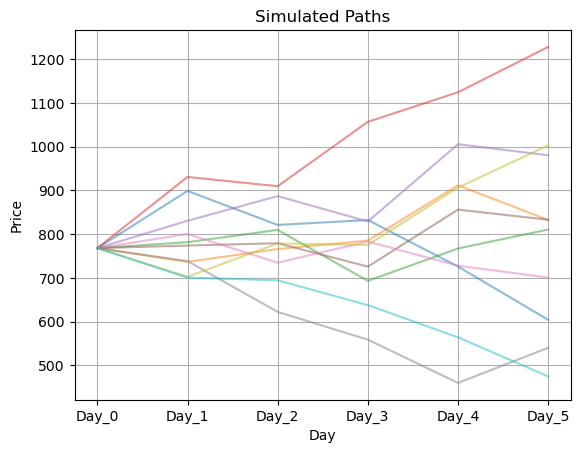

In [17]:
df_sim_norm.T.plot(legend=False, alpha=0.5)
#plt.plot(cap_line, linestyle='--', color='red', linewidth=2, label='+30% per day')
#plt.plot(cap_line_neg, linestyle='--', color='blue', linewidth=2, label='-30% per day')
plt.title("Simulated Paths")
plt.xlabel("Day")
plt.ylabel("Price")
plt.grid(True)
plt.show()

In [18]:
price_last_day = df_sim_norm['Day_5']

# ปัดทศนิยม 2 ตำแหน่ง
rounded_prices = price_last_day.round(150)


In [19]:
price_counts = rounded_prices.value_counts().sort_index()
price_probs = price_counts / price_counts.sum()


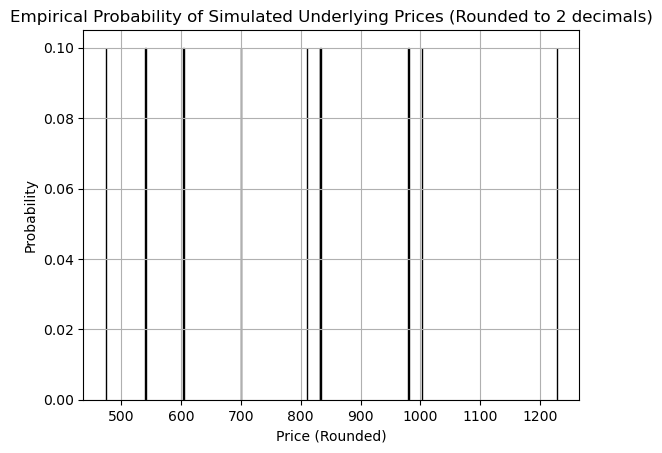

In [20]:
plt.bar(price_probs.index, price_probs.values, width=0.5, edgecolor='black')
plt.title("Empirical Probability of Simulated Underlying Prices (Rounded to 2 decimals)")
plt.xlabel("Price (Rounded)")
plt.ylabel("Probability")
plt.grid(True)
plt.show()

วิธีหา prob

In [22]:
prob_exact = price_probs.get(850.66, 0)
prob_le_800 = price_probs[price_probs.index <= 800.00].sum()

print(f"P(S = 850.66) = {prob_exact:.4%}")
print(f"P(S ≤ 800.00) = {prob_le_800:.4%}")


P(S = 850.66) = 0.0000%
P(S ≤ 800.00) = 40.0000%


In [23]:
# เช็กราคาที่พบเยอะที่สุด
rounded_prices.value_counts().head(10)


Day_5
604.232104     1
832.228590     1
810.622742     1
1227.846615    1
980.189431     1
832.854763     1
700.718447     1
540.429004     1
1002.974850    1
474.879620     1
Name: count, dtype: int64

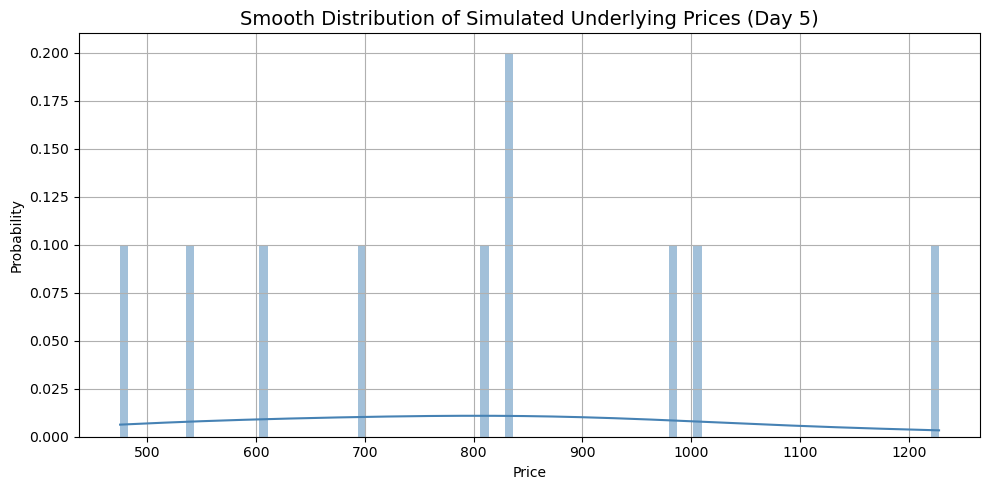

In [24]:
plt.figure(figsize=(10, 5))

sns.histplot(
    price_last_day,              # ใช้ราคาจริง (ไม่ต้อง round)
    bins=100,
    kde=True,                    # เส้น KDE smoothing
    stat="probability",         # ให้แกน y เป็นความน่าจะเป็น
    color="steelblue",
    edgecolor=None
)

plt.title("Smooth Distribution of Simulated Underlying Prices (Day 5)", fontsize=14)
plt.xlabel("Price")
plt.ylabel("Probability")
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
# รวม log-return ทุกวัน ทุก path
all_returns = df_sim_return.values.flatten()

# ปัดทศนิยม 4 ตำแหน่ง
rounded_returns = np.round(all_returns, 4)


In [26]:
# นับจำนวนและเปลี่ยนเป็น prob
ret_counts = pd.Series(rounded_returns).value_counts().sort_index()
ret_probs = ret_counts / ret_counts.sum()


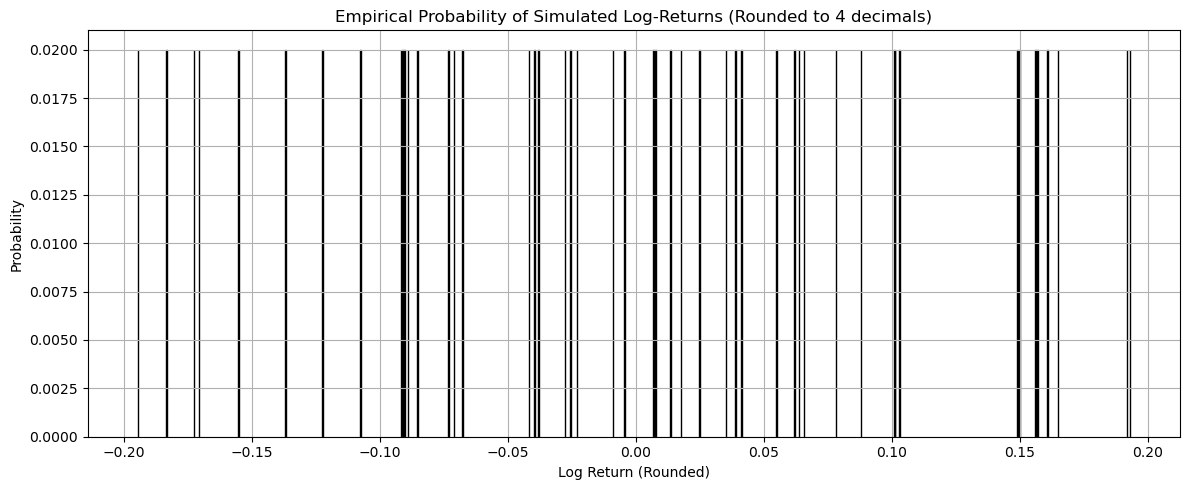

In [27]:
plt.figure(figsize=(12, 5))
plt.bar(ret_probs.index, ret_probs.values, width=0.0002, edgecolor='black')

plt.title("Empirical Probability of Simulated Log-Returns (Rounded to 4 decimals)")
plt.xlabel("Log Return (Rounded)")
plt.ylabel("Probability")
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
prob_exact = ret_probs.get(0.021, 0)  # P(r = 2.1%)
prob_le_neg1pct = ret_probs[ret_probs.index <= -0.01].sum()  # P(r <= -1%)

print(f"P(Return = 2.1%) = {prob_exact:.4%}")
print(f"P(Return ≤ -1%) = {prob_le_neg1pct:.4%}")


P(Return = 2.1%) = 0.0000%
P(Return ≤ -1%) = 46.0000%


<Axes: ylabel='Probability'>

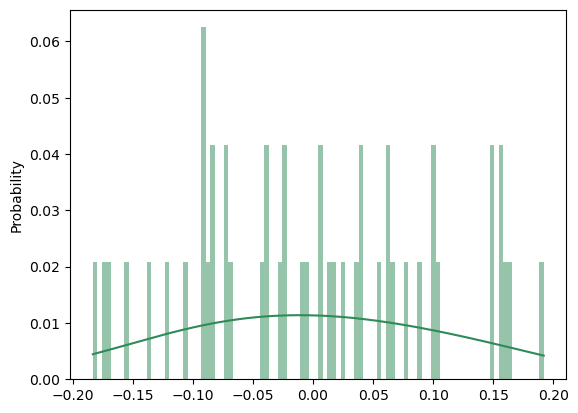

In [29]:
r = pd.Series(all_returns)
r_trimmed = r[(r > r.quantile(0.01)) & (r < r.quantile(0.99))]

sns.histplot(
    r_trimmed,
    bins=100,
    kde=True,
    stat="probability",
    color="seagreen",
    edgecolor=None,
    kde_kws={'bw_adjust': 1.5}
)


<Axes: ylabel='Probability'>

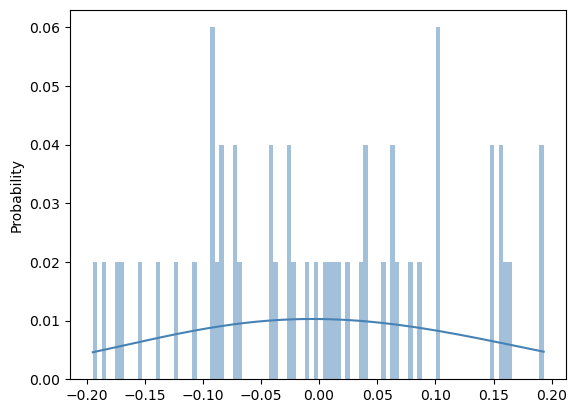

In [30]:
sns.histplot(
    all_returns,
    bins=100,
    kde=True,
    stat="probability",
    color="steelblue",
    edgecolor=None,
    kde_kws={'bw_adjust': 2}   # ปรับ bandwidth ให้กว้างขึ้น
)


In [31]:
r_total = df_sim_return.sum(axis=1)

# 2. คำนวณ log-return เป้าหมาย
target_return = np.log(100 / 800)  # = -2.0794

# 3. หา empirical probability
prob = np.mean(r_total <= target_return)
prob*= 100
print(f"P(S₅ ≤ 100 | S₀ = 800) = {prob:.6f}")

P(S₅ ≤ 100 | S₀ = 800) = 0.000000


In [32]:
r_total

0   -0.239975
1    0.080174
2    0.053870
3    0.469084
4    0.243813
5    0.080926
6   -0.091827
7   -0.351570
8    0.266793
9   -0.480872
dtype: float64

Recommended By Bros

In [34]:
from scipy.stats import truncnorm

In [35]:
# --- Parameters ---
mu = 0
sigma = cap   # std dev ที่เราใช้เดิม
log_cap = np.log(1 + cap)

# --- Truncated normal bounds (ในหน่วย std dev)
a, b = (-log_cap - mu) / sigma, (log_cap - mu) / sigma

# --- สุ่ม log-return จาก truncated normal
shocks = truncnorm.rvs(a, b, loc=mu, scale=sigma, size=n_sim)

In [36]:
shocks

array([ 0.00527755,  0.18007148, -0.07390892, -0.15668604, -0.01709493,
       -0.10464002, -0.15157312, -0.05445447,  0.03306773,  0.03257342])

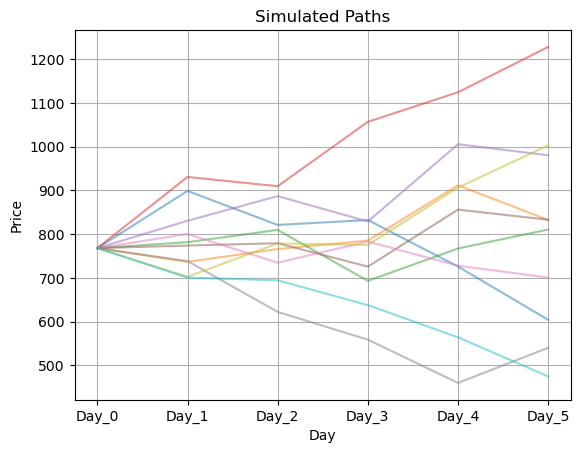

In [37]:
df_sim_norm.T.plot(legend=False, alpha=0.5)
#plt.plot(cap_line, linestyle='--', color='red', linewidth=2, label='+30% per day')
#plt.plot(cap_line_neg, linestyle='--', color='blue', linewidth=2, label='-30% per day')
plt.title("Simulated Paths")
plt.xlabel("Day")
plt.ylabel("Price")
plt.grid(True)
plt.show()

In [38]:

def simulate_paths_truncnorm(n_sim=5000, n_days=5, S0=800, cap=0.3, mu=0.0, sigma=None):
    """
    สุ่ม path ของราคาและ log-return ภายใต้ข้อจำกัด return ±cap ต่อวัน โดยใช้ truncated normal

    Parameters:
    ----------
    n_sim : int           จำนวน path ที่ต้องการ
    n_days : int          จำนวนวัน (ช่วงเวลา)
    S0 : float            ราคาตั้งต้น
    cap : float           ขอบเขตของ simple return (เช่น 0.3 = ±30%)
    mu : float            ค่าเฉลี่ยของ log-return รายวัน
    sigma : float         ส่วนเบี่ยงเบนมาตรฐานของ log-return (default = cap)

    Returns:
    --------
    df_price : DataFrame  ราคาจำลอง shape = (n_sim, n_days+1)
    df_return : DataFrame log-return shape = (n_sim, n_days)
    """
    if sigma is None:
        sigma = cap

    log_cap = np.log(1 + cap)  # bound ของ log-return

    # standardized bounds (Z-score)
    a, b = (-log_cap - mu) / sigma, (log_cap - mu) / sigma

    # สุ่ม log-return: shape = (n_sim, n_days)
    sim_returns = truncnorm.rvs(a, b, loc=mu, scale=sigma, size=(n_sim, n_days))

    # คำนวณราคาจาก log-return
    prices = np.zeros((n_sim, n_days + 1))
    prices[:, 0] = S0
    for t in range(1, n_days + 1):
        prices[:, t] = prices[:, t - 1] * np.exp(sim_returns[:, t - 1])

    # สร้าง DataFrame
    columns_price = [f"Day_{i}" for i in range(n_days + 1)]
    columns_return = [f"R_{i}" for i in range(1, n_days + 1)]

    df_price = pd.DataFrame(prices, columns=columns_price)
    df_return = pd.DataFrame(sim_returns, columns=columns_return)

    return df_price, df_return


In [39]:
df_sim_price, df_sim_return = simulate_paths_truncnorm(
    n_sim=n_sim,
    n_days=n_days,
    S0=S0,
    cap=cap,
    mu=0.0,            # สมมุติว่าค่าเฉลี่ยเป็นศูนย์
    sigma=cap          # ใช้ cap เดียวกันเป็น std ก็ได้ หรือแยกก็ได้
)


In [40]:
df_sim_price

,Day_0,Day_1,Day_2,Day_3,Day_4,Day_5
0,768.11,795.636608,835.024491,699.070968,665.566565,569.587944
1,768.11,653.510949,551.478735,487.258457,524.064821,629.700473
2,768.11,700.967830,662.381404,582.700491,601.637374,716.432011
3,768.11,708.099321,783.911355,791.622298,930.091667,949.716872
4,768.11,660.814970,548.326847,663.236168,794.039601,931.432649
5,768.11,880.492067,827.367664,961.972654,849.397274,801.529408
6,768.11,796.833140,771.122682,642.735472,708.897903,754.048129
7,768.11,709.627296,636.423452,701.085425,670.635524,745.810892
8,768.11,653.245500,553.626293,602.373077,683.819400,781.188630
9,768.11,637.604244,679.127632,682.626020,602.345213,530.242101


In [41]:
df_sim_return.describe()

,R_1,R_2,R_3,R_4,R_5
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,-0.070377,-0.056923,-0.007472,0.032771,0.049861
std,0.106780,0.102893,0.138030,0.113129,0.125588
min,-0.186215,-0.186602,-0.182114,-0.125116,-0.155725
25%,-0.158795,-0.151316,-0.127078,-0.047936,-0.038284
50%,-0.086410,-0.059426,0.007463,0.052401,0.083995
75%,0.006609,0.028039,0.093671,0.119607,0.152974
max,0.136548,0.101712,0.190260,0.180002,0.183629


In [42]:
price_last_day = df_sim_price['Day_5']

# ปัดทศนิยม 2 ตำแหน่ง
rounded_prices = price_last_day.round(2)


In [43]:
price_counts = rounded_prices.value_counts().sort_index()
price_probs = price_counts / price_counts.sum()


In [44]:
price_probs.describe()

count    1.000000e+01
mean     1.000000e-01
std      1.462847e-17
min      1.000000e-01
25%      1.000000e-01
50%      1.000000e-01
75%      1.000000e-01
max      1.000000e-01
Name: count, dtype: float64

In [45]:
prob_exact = price_probs.get(850.66, 0)
prob_le_800 = price_probs[price_probs.index <= 800.00].sum()

print(f"P(S = 850.66) = {prob_exact:.4%}")
print(f"P(S ≤ 800.00) = {prob_le_800:.4%}")


P(S = 850.66) = 0.0000%
P(S ≤ 800.00) = 70.0000%


In [46]:
# เช็กราคาที่พบเยอะที่สุด
rounded_prices.value_counts().head(10)


Day_5
569.59    1
629.70    1
716.43    1
949.72    1
931.43    1
801.53    1
754.05    1
745.81    1
781.19    1
530.24    1
Name: count, dtype: int64

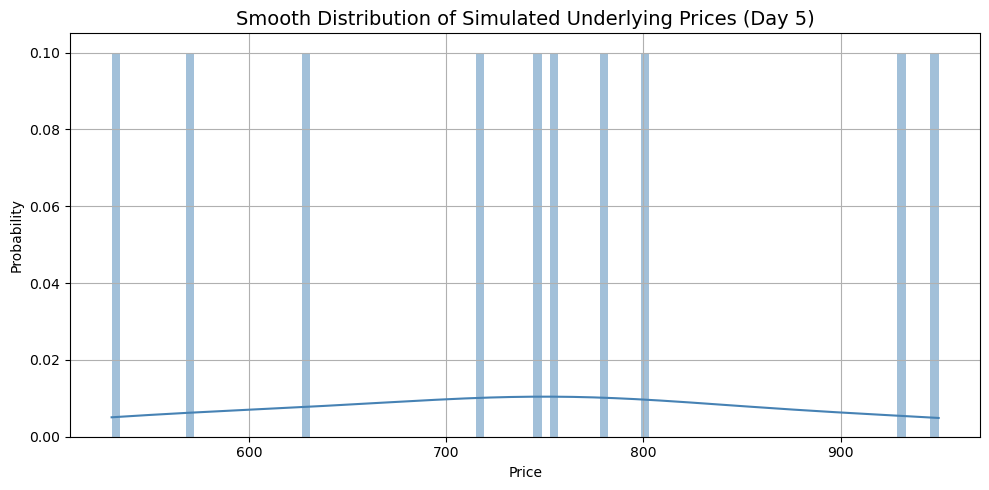

In [47]:
plt.figure(figsize=(10, 5))

sns.histplot(
    price_last_day,              # ใช้ราคาจริง (ไม่ต้อง round)
    bins=100,
    kde=True,                    # เส้น KDE smoothing
    stat="probability",         # ให้แกน y เป็นความน่าจะเป็น
    color="steelblue",
    edgecolor=None
)

plt.title("Smooth Distribution of Simulated Underlying Prices (Day 5)", fontsize=14)
plt.xlabel("Price")
plt.ylabel("Probability")
plt.grid(True)
plt.tight_layout()
plt.show()


In [48]:
all_returns = df_sim_return.values.flatten()

# ปัดทศนิยม 4 ตำแหน่ง
rounded_returns = np.round(all_returns, 4)


In [49]:
# นับจำนวนและเปลี่ยนเป็น prob
ret_counts = pd.Series(rounded_returns).value_counts().sort_index()
ret_probs = ret_counts / ret_counts.sum()


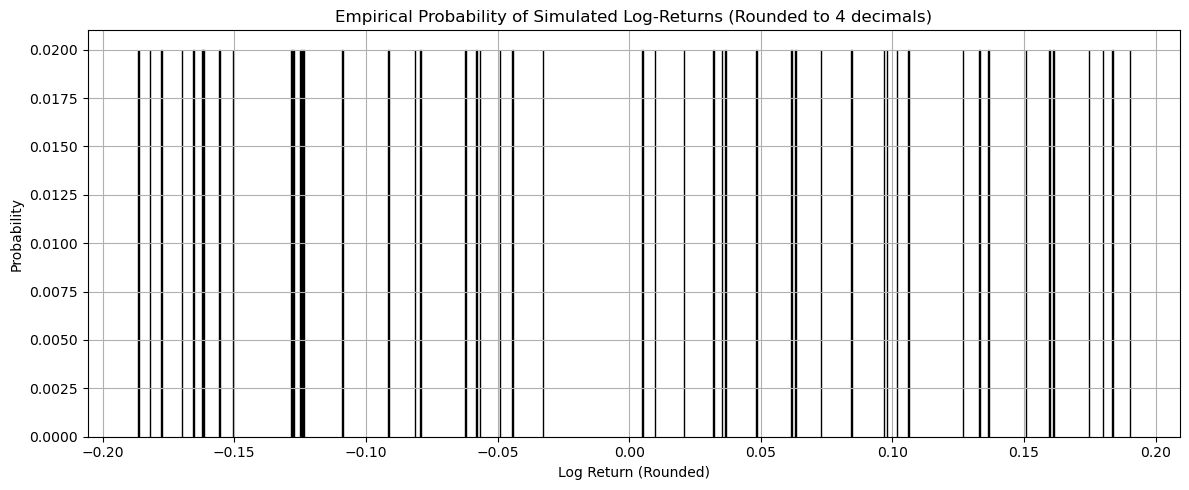

In [50]:
plt.figure(figsize=(12, 5))
plt.bar(ret_probs.index, ret_probs.values, width=0.0002, edgecolor='black')

plt.title("Empirical Probability of Simulated Log-Returns (Rounded to 4 decimals)")
plt.xlabel("Log Return (Rounded)")
plt.ylabel("Probability")
plt.grid(True)
plt.tight_layout()
plt.show()


In [51]:
prob_exact = ret_probs.get(0.021, 0)  # P(r = 2.1%)
prob_le_neg1pct = ret_probs[ret_probs.index <= -0.01].sum()  # P(r <= -1%)

print(f"P(Return = 2.1%) = {prob_exact:.4%}")
print(f"P(Return ≤ -1%) = {prob_le_neg1pct:.4%}")


P(Return = 2.1%) = 0.0000%
P(Return ≤ -1%) = 50.0000%


<Axes: ylabel='Probability'>

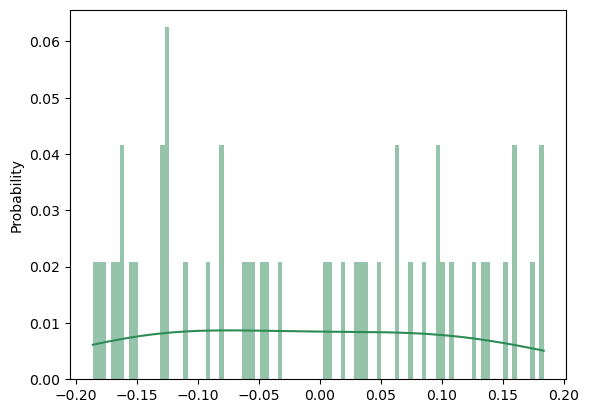

In [52]:
r = pd.Series(all_returns)
r_trimmed = r[(r > r.quantile(0.01)) & (r < r.quantile(0.99))]

sns.histplot(
    r_trimmed,
    bins=100,
    kde=True,
    stat="probability",
    color="seagreen",
    edgecolor=None,
    kde_kws={'bw_adjust': 1.5}
)


In [53]:
r_total = df_sim_return.sum(axis=1)

# 2. คำนวณ log-return เป้าหมาย
target_return = np.log(100 / 800)  # = -2.0794

# 3. หา empirical probability
prob = np.mean(r_total <= target_return)
prob*= 100
print(f"P(S₅ ≤ 100 | S₀ = 800) = {prob:.6f}")

P(S₅ ≤ 100 | S₀ = 800) = 0.000000


In [27]:
# Step 1: คำนวณ log-return รายวัน
df_price['LogReturn'] = np.log(df_price['Price']).diff()

# Step 2: สร้าง label
def classify_regime(r):
    if r <= -0.05:
        return "crash"
    else:
        return "normal"

df_price['Regime'] = df_price['LogReturn'].apply(classify_regime)


In [29]:
def simulate_paths_empirical_mixture_drop_exceed(n_sim, n_days, S0,
                                                  mu_1, sigma_1,
                                                  mu_2, p_crash):
    """
    สุ่ม path โดยใช้ empirical mixture:
    - normal: ใช้ mu_1, sigma_1 + 0.1
    - crash: ใช้ mu_2, sigma_crash = 0.3 (fixed)
    หากมี log-return ใดเกิน ±log(1.3) ใน path → drop path นั้นทันที
    """
    sigma_crash = 0.3
    sigma_normal = sigma_1 + 0.1
    log_cap = np.log(1 + 0.3)

    returns_list = []
    prices_list = []

    while len(returns_list) < n_sim:
        returns = []
        valid = True

        for _ in range(n_days):
            if np.random.rand() < p_crash:
                r = np.random.normal(mu_2, sigma_crash)
                
            else:
                r = np.random.normal(mu_1, sigma_normal)

            if abs(r) > log_cap:
                valid = False
                break

            returns.append(r)

        if valid:
            prices = [S0]
            for r in returns:
                prices.append(prices[-1] * np.exp(r))

            returns_list.append(returns)
            prices_list.append(prices)

    # สร้าง DataFrames
    df_price = pd.DataFrame(prices_list, columns=[f"Day_{i}" for i in range(n_days + 1)])
    df_return = pd.DataFrame(returns_list, columns=[f"R_{i}" for i in range(1, n_days + 1)])

    return df_price, df_return

In [31]:
# ปรับ simulation ให้มี crash เกิดขึ้นจริง โดยเพิ่ม volatility
np.random.seed(42)
price_series = 800 * np.cumprod(np.exp(np.random.normal(0, 0.03, 1000)))  # ใช้ std = 0.03
df_price = pd.DataFrame({'Price': price_series})

# Step 1: คำนวณ log-return
df_price['LogReturn'] = np.log(df_price['Price']).diff()
df_price.dropna(inplace=True)

# Step 2: แบ่ง regime
threshold = 0.05  # หรือ log(1.05) ถ้าใช้ log-return
df_price['Regime'] = df_price['LogReturn'].apply(
    lambda r: 'crash' if abs(r) >= threshold else 'normal'
)


# Step 3: แยก return ตาม regime
normal_returns = df_price[df_price['Regime'] == 'normal']['LogReturn']
crash_returns = df_price[df_price['Regime'] == 'crash']['LogReturn']

# Step 4: คำนวณ mean และ std ที่ต้องใช้
mu_1 = normal_returns.mean()
sigma_1 = normal_returns.std()
mu_2 = crash_returns.mean()
sigma_2 = crash_returns.std()

n_crash = (df_price['Regime'] == 'crash').sum()
n_total = len(df_price)
p_crash = n_crash / n_total

(mu_1, sigma_1, mu_2, sigma_2)

(-0.0004601599608993235,
 0.02366055212905916,
 0.01105399791570578,
 0.06236650894947568)

In [33]:
df_sim_price, df_sim_return = simulate_paths_empirical_mixture_drop_exceed(
    n_sim=n_sim,
    n_days=n_days,
    S0=S0,
    mu_1=mu_1,
    sigma_1=sigma_1,
    mu_2=mu_2,
    p_crash=p_crash
)

In [34]:
df_sim_price.describe()

,Day_0,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,...,Day_51,Day_52,Day_53,Day_54,Day_55,Day_56,Day_57,Day_58,Day_59,Day_60
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,7.681100e+02,773.733252,777.560701,781.431536,786.575945,792.213085,797.352567,801.733657,807.680929,811.347058,...,1066.847300,1072.251236,1077.347042,1087.660227,1094.493630,1101.379085,1108.623892,1114.604492,1121.264434,1128.265849
std,1.289273e-10,88.879382,126.252381,154.836222,180.601204,206.312204,226.693097,246.609745,266.449647,285.265566,...,1036.141213,1048.678534,1062.563174,1098.050368,1121.039906,1148.094198,1171.762203,1188.365254,1198.849851,1220.615418
min,7.681100e+02,591.044522,468.099467,390.772033,350.681320,328.142878,293.221460,262.632814,239.573818,206.664792,...,31.526639,27.705458,28.171205,26.303709,22.711631,26.346371,24.633880,30.777484,31.967645,28.288305
25%,7.681100e+02,708.539156,685.080736,668.074261,654.989065,642.439258,632.806210,622.016847,617.175380,608.199929,...,440.201482,433.842615,430.326468,427.412367,423.937758,422.253437,425.350639,421.198347,418.563255,415.765372
50%,7.681100e+02,769.739176,769.143416,766.230346,765.359308,765.392834,766.595552,767.938972,769.816278,767.653581,...,760.271690,763.236420,760.210620,758.674093,759.711482,756.861812,753.427144,753.020200,753.714408,753.118547
75%,7.681100e+02,834.761302,860.155443,877.087040,895.518467,911.394966,928.570950,940.957061,953.103789,963.854453,...,1333.194946,1337.106931,1349.282206,1353.180463,1364.690506,1378.718167,1378.389733,1385.740292,1398.335650,1405.253880
max,7.681100e+02,997.803471,1257.244017,1473.625650,1696.224381,1989.473388,2051.783161,1978.549941,2348.664766,2691.067518,...,16343.690819,14689.109931,15705.197283,19239.410243,22046.974013,25674.425982,25384.757709,24397.021286,23871.586238,26637.071169


In [35]:
df_sim_return.describe()

,R_1,R_2,R_3,R_4,R_5,R_6,R_7,R_8,R_9,R_10,...,R_51,R_52,R_53,R_54,R_55,R_56,R_57,R_58,R_59,R_60
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.000699,-0.001531,-0.001262,0.000158,0.000137,0.000145,-0.000994,0.000977,-0.001931,-0.000884,...,-0.000968,-0.001381,-0.000838,0.001677,-0.000507,-0.000350,-0.000090,-0.001279,0.000892,-0.000049
std,0.114964,0.113763,0.113589,0.114316,0.113965,0.114770,0.113281,0.113761,0.113002,0.113933,...,0.113915,0.114007,0.114535,0.112953,0.113936,0.113164,0.114099,0.114731,0.113938,0.114691
min,-0.262042,-0.261915,-0.262343,-0.261683,-0.262231,-0.262303,-0.262283,-0.262032,-0.261970,-0.262260,...,-0.262217,-0.261787,-0.261815,-0.262212,-0.262322,-0.262174,-0.262252,-0.262334,-0.262325,-0.262122
25%,-0.080728,-0.084386,-0.083882,-0.082250,-0.082674,-0.082408,-0.083266,-0.081223,-0.084344,-0.083336,...,-0.082449,-0.083939,-0.083298,-0.077249,-0.083804,-0.081608,-0.082170,-0.084751,-0.081750,-0.082442
50%,0.002119,0.000002,-0.001481,-0.001255,0.001231,0.000219,0.000279,0.000540,-0.002093,-0.001738,...,-0.000999,-0.002139,-0.001200,0.001308,-0.001058,0.000021,-0.001154,-0.001210,0.001537,-0.000166
75%,0.083213,0.079640,0.080141,0.082142,0.081421,0.082893,0.081113,0.084298,0.078287,0.080944,...,0.079725,0.080849,0.081720,0.081659,0.082386,0.080137,0.083355,0.082749,0.083510,0.081697
max,0.261623,0.262184,0.262183,0.261739,0.262175,0.261858,0.262190,0.261528,0.262315,0.262348,...,0.262360,0.262261,0.261964,0.262011,0.262081,0.262236,0.262346,0.262084,0.261774,0.262157


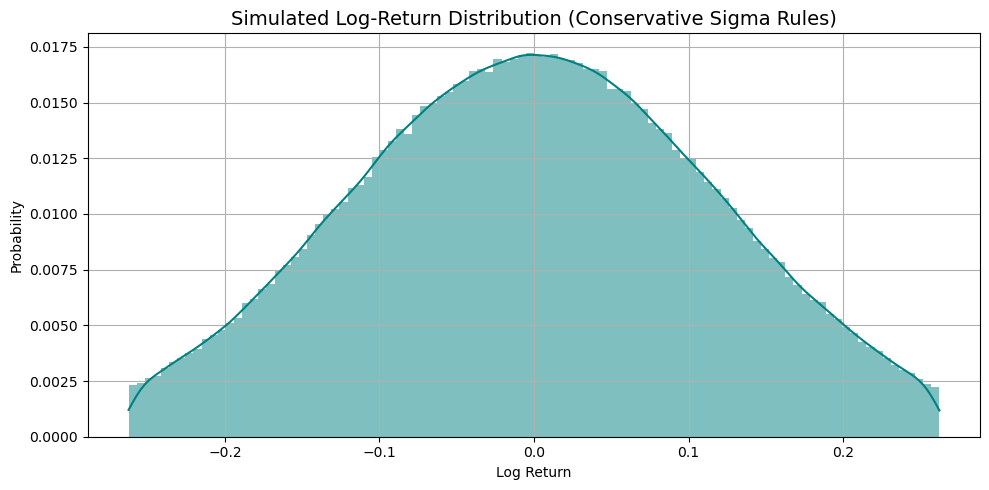

In [36]:
all_returns = df_sim_return.values.flatten()
all_returns = all_returns[np.isfinite(all_returns)]

plt.figure(figsize=(10, 5))
sns.histplot(all_returns, bins=100, kde=True, stat="probability", color="teal", edgecolor=None)
plt.title("Simulated Log-Return Distribution (Conservative Sigma Rules)", fontsize=14)
plt.xlabel("Log Return")
plt.ylabel("Probability")
plt.grid(True)
plt.tight_layout()
plt.show()

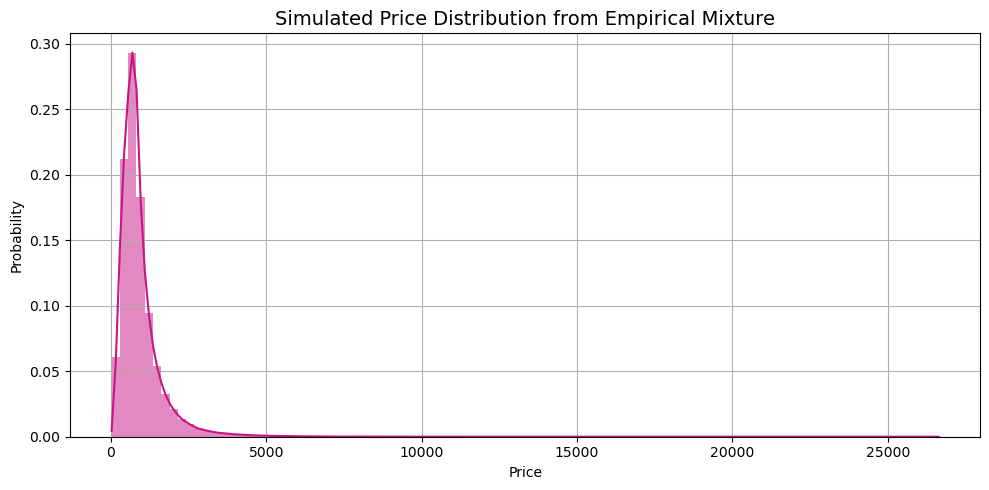

In [37]:

all_returns = df_sim_price.values.flatten()
all_returns = all_returns[np.isfinite(all_returns)]

plt.figure(figsize=(10, 5))
sns.histplot(all_returns, bins=100, kde=True, stat="probability", color="mediumvioletred", edgecolor=None)
plt.title("Simulated Price Distribution from Empirical Mixture", fontsize=14)
plt.xlabel("Price")
plt.ylabel("Probability")
plt.grid(True)
plt.tight_layout()
plt.show()

งง

In [55]:
def estimate_price_probability(df_price, round_to=2):
    """
    รับ DataFrame ของราคาจำลอง (df_price) ที่มี columns เป็น Day_0, Day_1, ...
    แล้วคืน DataFrame ใหม่ที่เก็บความน่าจะเป็นของราคาที่ปรากฏในแต่ละวัน (แบบ rounded)

    Parameters:
    -----------
    df_price : pd.DataFrame
        จำลองราคาทั้งหมด โดยมี index = path และ columns = Day_i
    round_to : int
        จำนวนตำแหน่งทศนิยมที่ใช้ปัดราคา

    Returns:
    --------
    df_prob : pd.DataFrame
        DataFrame ที่มี index = ราคาที่ปัดแล้ว, columns = Day_i, ค่าคือ probability
    """
    rounded_price = df_price.round(round_to)
    prob_dict = {}

    for col in df_price.columns:
        counts = rounded_price[col].value_counts(normalize=True).sort_index()
        prob_dict[col] = counts

    df_prob = pd.DataFrame(prob_dict).fillna(0)
    df_prob.index.name = "RoundedPrice"

    return df_prob

# สร้าง DataFrame ความน่าจะเป็นของราคาจาก df_sim_price_drop (ใช้รอบล่าสุดที่ drop exceed cap)
df_price_prob = estimate_price_probability(df_sim_price, round_to=0)

In [59]:
df_price_prob*100

,Day_0,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,...,Day_51,Day_52,Day_53,Day_54,Day_55,Day_56,Day_57,Day_58,Day_59,Day_60
RoundedPrice,,,,,,,,,,,,,,,,,,,,,
23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00
25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00
26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.00
27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00
28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.01,0.01,0.00,0.00,0.00,0.01,0.00,0.00,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23872.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00
24397.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00
25385.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00
